## This is a customer segmentation model based on a sample of retail data. 

## Assumptions: 
### We assume that today's date is 9/31/2019.

In [12]:
# Import Python libraries
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

In [13]:
# Load the queried data
customer_table = pd.read_csv('customer_table.csv')
customer_table.head()

,customer_id,num_prod_purchased,ltv,days_since_last_purchase,tenure,single_more6,single_less6,multi_buyer_less6,multi_buyer_more6
0,52,2,75.0,92,90,0,0,1,0
1,56,1,20.0,923,63,1,0,0,0
2,95,2,145.0,631,72,0,0,0,1
3,368,4,215.0,116,142,0,0,1,0
4,372,4,255.0,560,101,0,0,0,1


## Feature Selection:

### The features selected reflect recency, frequency and monetary value of the customer's purchases. The features and their justifications are described below in more detail.
### ** num_prod_purchased (number of products purchased)
#### If a customer has purchased more products, they are more likely to purchase in the future. This field was calculated by counting the number of transaction ids associated with the customer.
### ** ltv (lifetime value)
#### If a customer has spent more money, they are more likely to spend in the future. Lifetime value was calculated by determining the sum of all transaction costs for each customer.
### ** days_since_last_purchase (the number of days since the customer's last order) 
#### If a customer made their last purchase over a year ago, for example, they are less likely to purchase a product now. If the customer has never purchased, they were marked with a -1. I selected -1 to differentiate customers who purchased from those that didn't.
### ** tenure (weeks between sign up date and today's date) 
#### If a customer has been active longer and made multiple purchases consistently, they are a great customer. Yet, if a customer hasn't purchased much, an explanation could be their shorter tenure. If a customer didn't have a sign up date, their first purchase date was used. If they don't have both a first purchase date and sign up date, they were marked with a -1.
### ** single_more6 (customers who made a single transaction more than 6 months ago)
#### A binary variable indicating customers who made 1 transaction over 6 months ago.
### ** single_less6 (customers who made a single transaction less than 6 months ago)
#### A binary variable indicating customers who made 1 transaction within the last 6 months.
### ** multi_buyer_less6 (customers who made multiple transactions less than 6 months ago)
#### A binary variable indicating customers who made more than 1 transaction within the last 6 months. 
### ** multi_buyer_more6
#### A binary variable indicating customers who made more than 1 transaction over 6 months ago.

### ** Other features that were explored but not included were: average_days_between_transactions and median_days_between_transactions.
#### I removed these features because I felt they were not necessary. For the variables average_days_between_transactions and median_days_between_transactions, they would be more useful in predicting how a customer would purchase but not in cluster segmentation. 

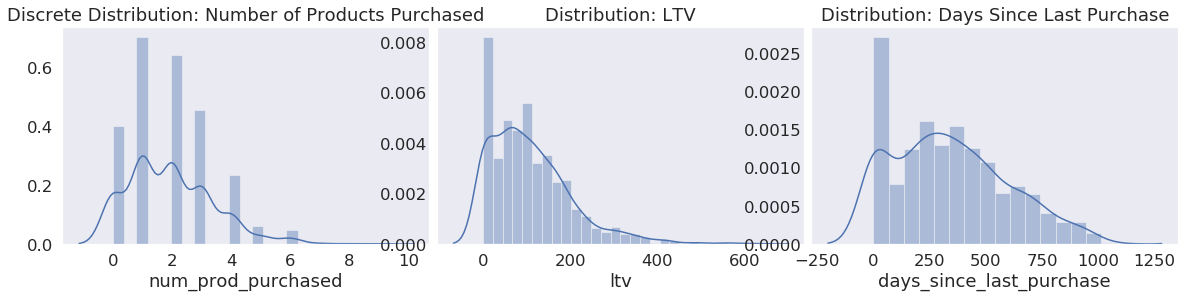

In [14]:
# Explore the distributions of the variables in the dataset
mpl.rcParams['figure.figsize'] = (20,4)

plt.subplot(1, 3, 1)
plt.title('Discrete Distribution: Number of Products Purchased')
sns.distplot(customer_table['num_prod_purchased'])
plt.subplot(1, 3, 2)
plt.title('Distribution: LTV')
sns.distplot(customer_table['ltv'])
plt.subplot(1, 3, 3)
plt.title('Distribution: Days Since Last Purchase')
sns.distplot(customer_table['days_since_last_purchase'])
plt.subplots_adjust(wspace=0.02, hspace=1)
plt.show()


### Of these variables, I chose to explore the LTV distribution to see if I could make it more normally distributed. It doesn't make sense to normalize days since last purchase, since I have marked those that didn't make a purchase with a -1.

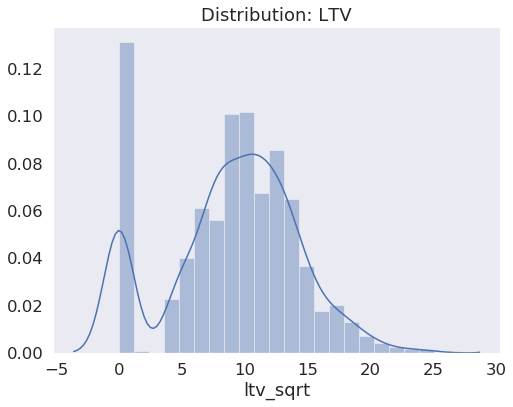

In [15]:
mpl.rcParams['figure.figsize'] = (8,6)
customer_table['ltv_sqrt'] = np.sqrt(customer_table['ltv'])
plt.title('Distribution: LTV')
sns.distplot(customer_table['ltv_sqrt'])



### I explored normalizing the data for lifetime value as shown above, but I chose not to use normalized LTV. I tested out my results with the normalized lifetime value variable, but the clusters were more clearly defined when using the original distribution. Therefore, I did not use the ltv_sqrt variable that I defined above when proceeding with the analysis.

### I looked at outliers by calculating the interquartile range (IQR) for LTV. I chose not to remove outliers because the clusters were sensitive to outlier removal. This could have been influenced by the fact that the sample size is  smaller (only 1000 customers), and each customer in this sample reflects the overall population.

In [16]:
# Drop the user_id and unused fields. The user_id will be appended back into the dataset later.
cust_fields = customer_table.drop(['customer_id','ltv_sqrt'], axis = 1)

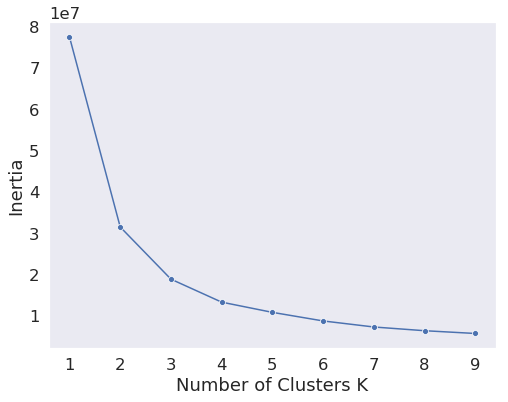

In [17]:
# Create an elbow plot to identify the number of clusters.
cust_fields_elbow = cust_fields

sse={}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,max_iter=500).fit(cust_fields_elbow)
    cust_fields_elbow['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
sns.set(font_scale=1.5)
sns.set_style({'axes.grid' : False})
sns.lineplot(list(sse.keys()), list(sse.values()),marker="o")
plt.xlabel("Number of Clusters K")
plt.ylabel('Inertia')
plt.show()

### There is an elbow around 3-4 clusters. I will select 3 clusters for the analysis.

In [18]:
# Set the seed so the cluster assignment is the same each time.
np.random.seed(200) 

# Determine the clusters across the dataset
kmeans = KMeans(n_clusters=3)
kmeans.fit(cust_fields)
cust_fields['Cluster'] = kmeans.predict(cust_fields)

In [19]:
# Rename the clusters 
cust_fields['Cluster'].replace({2:"Worst",0:'Recent',1:'Best'},inplace=True)

# Show the average results across each cluster
summary_cust_fields = cust_fields.groupby('Cluster').mean()
cm = sns.light_palette("seagreen", as_cmap=True)
(summary_cust_fields.style.background_gradient(cmap=cm, subset=[ 'num_prod_purchased','ltv','tenure','days_since_last_purchase','single_more6','single_less6','multi_buyer_less6','multi_buyer_more6']))

,num_prod_purchased,ltv,days_since_last_purchase,tenure,single_more6,single_less6,multi_buyer_less6,multi_buyer_more6
Cluster,,,,,,,,
Best,2.68319,152.586,344.095,95.5884,0.200431,0,0.0258621,0.773707
Recent,1.22152,65.0316,59.8924,71.0032,0.0379747,0.0601266,0.360759,0.0316456
Worst,1.48193,84.0161,698.414,99.004,0.638554,0,0,0.361446


## Best Customers (Cluster 1)
### These are the best customers. They are the customers that have made the most purchases and spent the most (have the highest LTV).  We can see that many of these customers have purchased multiple products. 

## Worst - Haven't Purchased in a Long Time (Cluster 2) 
### All of these customers have made their last purchase over 6 months ago. The cluster's average number of days since their last purchase is over a year ago. They have purchased on average 1.5 products but spent a bit more than the recent customers. 

## Recent Transactors (Cluster 0) 
### These customers are more recent customers, having made purchases in the last 6 months. They haven't purchased that much in terms of quantity and monetary value, but have potential to purchase more. They have been on file for a shorter amount of time than the other two clusters -- an average of 71 weeks. 

In [23]:
# Total number of customers in each cluster
cust_fields.groupby('Cluster')['num_prod_purchased'].count()

Cluster
Best      464
Recent    316
Worst     249
Name: num_prod_purchased, dtype: int64

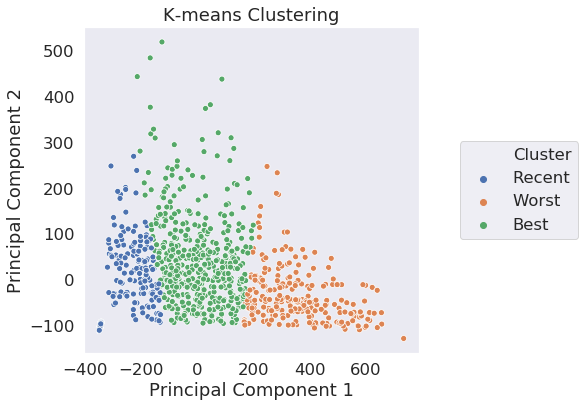

In [24]:
# Calculate Principal Components for the Dataset
fields = cust_fields.drop(['Cluster'],axis=1)
reduced_data = PCA(n_components=2).fit_transform(fields)
results = pd.DataFrame(reduced_data,columns=['Principal Component 1','Principal Component 2'])
g = sns.scatterplot(x="Principal Component 1", y="Principal Component 2", hue=cust_fields['Cluster'], data=results)
plt.title('K-means Clustering')

# Move legend to the side and resize the legend.
box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.75, box.height])
g.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)

# Display the clustering results.
plt.show()

### This shows the separation between the segments after reducing the dimensions using PCA. We can see clearly defined segments.

In [25]:
# Append user ids to the customer_table
segments = pd.concat([customer_table['customer_id'], cust_fields], axis=1, sort=False)

# Save the customer table with cluster assignments
segments.to_csv("segments.csv", index=False)
segments.head()

,customer_id,num_prod_purchased,ltv,days_since_last_purchase,tenure,single_more6,single_less6,multi_buyer_less6,multi_buyer_more6,Cluster
0,52,2,75.0,92,90,0,0,1,0,Recent
1,56,1,20.0,923,63,1,0,0,0,Worst
2,95,2,145.0,631,72,0,0,0,1,Worst
3,368,4,215.0,116,142,0,0,1,0,Recent
4,372,4,255.0,560,101,0,0,0,1,Worst
